<a href="https://colab.research.google.com/github/antonkurtis/DPO_Diplom/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import sklearn
from sklearn import metrics
from torchsummary import summary
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/data/seminars/anat/'

In [ ]:
X, y = np.load(data_dir + 'tensors.npy'), \
np.load(data_dir + 'labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(1113, 1, 58, 70, 58) (1113,)


In [ ]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
torch.cuda.is_available()

True

In [16]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
#Смотрим scv для текущего датасета
file = pd.read_csv('/content/drive/MyDrive/data/seminars/anat/unrestricted_hcp_freesurfer.csv')

In [ ]:
x = pd.read_csv('/content/drive/MyDrive/Учеба/unrestricted_kondratevakate_3_15_2021_8_41_42.csv')

In [ ]:
#Заменим str'интовый диапазон на какие-нибудь чиселки
x['Age'].unique()

array(['22-25', '26-30', '31-35', '36+'], dtype=object)

In [ ]:
x['Age'] = x['Age'].replace('22-25', 22)
x['Age'] = x['Age'].replace('26-30', 26)
x['Age'] = x['Age'].replace('31-35', 31)
x['Age'] = x['Age'].replace('36+', 36)

In [ ]:
#Добавим в датасет закоденные диапазоны возрастов по ID пациента
x_with_age = pd.merge(left= file,
         right= x,
         on='Subject')
y_age = x_with_age['Age']
y_age = np.array(y_age)

In [18]:
#Модель для регрессии
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
    nn.BatchNorm3d(c_out), # Batch Normalization layer
    nn.ReLU(), # Activational layer
    nn.MaxPool3d(2) # Pooling layer
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear1 = nn.Linear(128*5*7*5, 2000)
        self.linear2 = nn.Linear(2000, 1000)
        self.linear3 = nn.Linear(1000, 500)
        self.linear4 = nn.Linear(500, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32

In [21]:
c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
           Linear-14                 [-

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size=0.20, random_state=42) 

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [ ]:
#Функция для измерения mean_absolute_error модели
def get_accuracy(targets, predicts):
  new_predicts = []

  predicts = predicts.cpu().detach()
  targets = targets.cpu().detach()

  predict_list = [element.item() for element in predicts.flatten()]
  target_list = [element.item() for element in targets.flatten()]

  takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))

  for predict in predict_list:
    closest = takeClosest(predict, target_list)
    if predict < closest:
      new_predicts.append(math.ceil(predict))
    else:
      new_predicts.append(math.floor(predict))

  return mean_absolute_error(target_list, new_predicts)

In [ ]:
def train(train_loader, val_loader, criterion, optimizer, scheduler, n_epoch):
  torch.manual_seed(1)
  np.random.seed(1)
  acc_train = []
  acc_test = []

  loss_train = []
  loss_test = []

  for tqdm in range(1, n_epoch+1):
    for X, y in train_loader:
      
      batch_loss_train = []
      batch_acc_train = []
      
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_pred = model(X)
      loss = criterion(y_pred, y.float().view(len(y_pred), 1))
      batch_acc_train.append(get_accuracy(y, y_pred))
      batch_loss_train.append(loss.item())

      loss.backward()
      optimizer.step()
    
    acc_train.append(np.mean(batch_acc_train))
    loss_train.append(np.mean(batch_loss_train))
    print('Train epoch', tqdm)
    print('Train loss', loss_train[-1])
    print('Train error', acc_train[-1])

    with torch.no_grad():
      for X, y in val_loader:
        
        batch_loss_test = []
        batch_acc_test = []

        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.float().view(len(y_pred), 1))
        batch_acc_test.append(get_accuracy(y, y_pred))
        batch_loss_test.append(loss.item())
      
      acc_test.append(np.mean(batch_acc_test))
      loss_test.append(np.mean(batch_loss_test))
      print('Val loss', loss_test[-1])
      print('Val error', acc_test[-1])

    scheduler.step()
  return loss_train, loss_test, acc_train, acc_test

In [ ]:
def plot_history(loss_train, loss_test, acc_train, acc_test):
  plt.figure(figsize=(16,6))

  plt.subplot(1, 2, 1)
  plt.title('Loss history', fontsize=18)
  plt.plot(loss_train, label='Train')
  plt.plot(loss_test, label='Validation')
  plt.xlabel('# of epoch', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(fontsize=16)
  plt.minorticks_on()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.title('Accuracy history', fontsize=18)
  plt.plot(acc_train, label='Train')
  plt.plot(acc_test, label='Validation')
  plt.xlabel('# of epoch', fontsize=16)
  plt.ylabel('Accuracy', fontsize=16)
  plt.legend(fontsize=16)
  plt.minorticks_on()
  plt.grid()


In [ ]:
model = MriNet(c).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1)

In [ ]:
loss_train, loss_test, acc_train, acc_test = train(train_loader,val_loader, criterion, optimizer, scheduler, 25)

Train epoch 1
Train loss 5.194332599639893
Train error 5.0285714285714285
Val loss 4.613585472106934
Val error 4.518518518518518
Train epoch 2
Train loss 3.6341288089752197
Train error 3.6
Val loss 3.5215775966644287
Val error 3.5555555555555554
Train epoch 3
Train loss 3.505354881286621
Train error 3.1714285714285713
Val loss 5.937269687652588
Val error 5.555555555555555
Train epoch 4
Train loss 3.683046579360962
Train error 3.6285714285714286
Val loss 3.8961641788482666
Val error 3.7037037037037037
Train epoch 5
Train loss 3.1594290733337402
Train error 3.085714285714286
Val loss 4.302277565002441
Val error 4.222222222222222
Train epoch 6
Train loss 2.424147367477417
Train error 2.3142857142857145
Val loss 3.2580244541168213
Val error 3.4074074074074074
Train epoch 7
Train loss 3.0258100032806396
Train error 2.857142857142857
Val loss 4.519805431365967
Val error 4.703703703703703
Train epoch 8
Train loss 6.544462203979492
Train error 6.457142857142857
Val loss 4.028738498687744
Val e

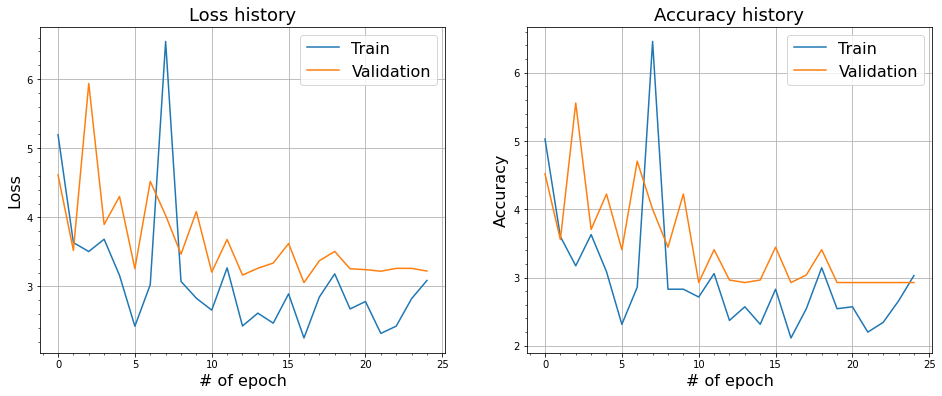

In [ ]:
plot_history(loss_train, loss_test, acc_train, acc_test)

In [ ]:
PATH = '/content/drive/MyDrive/Учеба/Diplom/model_weights'
torch.save(model, PATH)

ABIDE Dataset

In [3]:
selected_all_sum_tensor = torch.load('/content/drive/MyDrive/abideI-mni/T1_ss_mni_64_all-sites-I').float()
selected_all_sum_tensor = F.pad(selected_all_sum_tensor, pad=(6,6,6,6,6,6))

print(selected_all_sum_tensor.shape)

selected_all_sum_tensor = selected_all_sum_tensor[..., 10:68, 0:70, 18:76] 
selected_all_sum_tensor.shape

torch.Size([1093, 76, 76, 76])


torch.Size([1093, 58, 70, 58])

In [4]:
selected_all_sum_tensor = selected_all_sum_tensor[:, np.newaxis, :, :, :]

In [5]:
target_age = torch.load('/content/drive/MyDrive/abide/abideI-mni/ages_all-sites-I')

In [14]:
men = 0
for i in target_sex:
  if i == 1:
    men +=1
men

932

In [12]:
len(target_sex) - men

161

In [ ]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = X.type(torch.float32)
        self.y = y.type(torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(selected_all_sum_tensor, target_age, test_size=0.20, random_state=42) 

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True) 
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [ ]:
#Объявляем модель заново, без предобученных весов
model = MriNet(c).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1)

In [ ]:
loss_train, loss_test, acc_train, acc_test = train(train_loader,val_loader, criterion, optimizer, scheduler, 25)

Train epoch 1
Train loss 2.625865936279297
Train error 2.5142857142857142
Val loss 13.629283905029297
Val error 13.25925925925926
Train epoch 2
Train loss 3.539119005203247
Train error 3.4285714285714284
Val loss 4.379636287689209
Val error 4.111111111111111
Train epoch 3
Train loss 3.6712088584899902
Train error 3.5714285714285716
Val loss 4.424200534820557
Val error 4.555555555555555
Train epoch 4
Train loss 3.5028202533721924
Train error 3.4571428571428573
Val loss 3.7442076206207275
Val error 3.7037037037037037
Train epoch 5
Train loss 3.236586570739746
Train error 3.0285714285714285
Val loss 3.7826504707336426
Val error 3.925925925925926
Train epoch 6
Train loss 3.4785735607147217
Train error 3.4571428571428573
Val loss 3.494833469390869
Val error 3.6296296296296298
Train epoch 7
Train loss 4.663861274719238
Train error 4.714285714285714
Val loss 3.184532403945923
Val error 3.074074074074074
Train epoch 8
Train loss 2.4844095706939697
Train error 2.3142857142857145
Val loss 7.2830

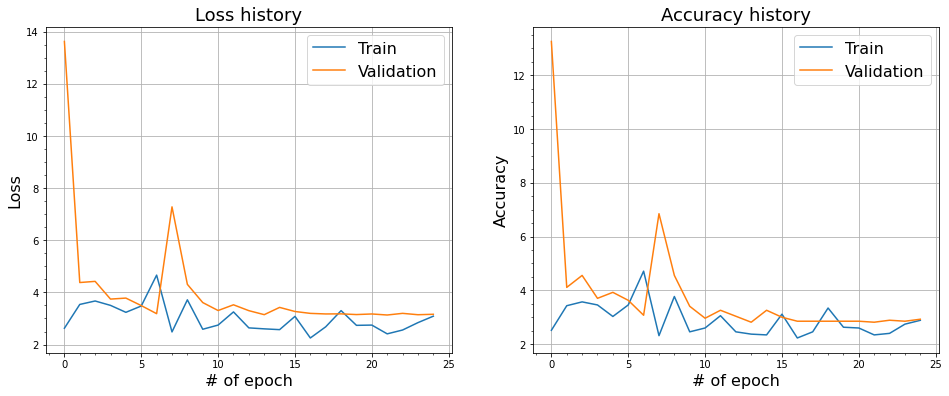

In [ ]:
plot_history(loss_train, loss_test, acc_train, acc_test)

In [ ]:
#Сохраненная модель с весами после первого обучения
model = torch.load(PATH)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1)

In [ ]:
loss_train, loss_test, acc_train, acc_test = train(train_loader,val_loader, criterion, optimizer, scheduler, 25)

Train epoch 1
Train loss 2.735785961151123
Train error 2.5714285714285716
Val loss 5.248795509338379
Val error 5.0
Train epoch 2
Train loss 3.539060354232788
Train error 3.4571428571428573
Val loss 3.3568646907806396
Val error 3.3703703703703702
Train epoch 3
Train loss 3.0334620475769043
Train error 2.9714285714285715
Val loss 4.21996545791626
Val error 4.296296296296297
Train epoch 4
Train loss 3.526890754699707
Train error 3.4571428571428573
Val loss 4.450408458709717
Val error 4.703703703703703
Train epoch 5
Train loss 5.211935520172119
Train error 5.228571428571429
Val loss 4.2634148597717285
Val error 4.444444444444445
Train epoch 6
Train loss 2.7347500324249268
Train error 2.4857142857142858
Val loss 3.685316562652588
Val error 3.7037037037037037
Train epoch 7
Train loss 5.87685489654541
Train error 5.6
Val loss 3.7600741386413574
Val error 3.888888888888889
Train epoch 8
Train loss 2.756159543991089
Train error 2.4857142857142858
Val loss 3.5673303604125977
Val error 3.37037037

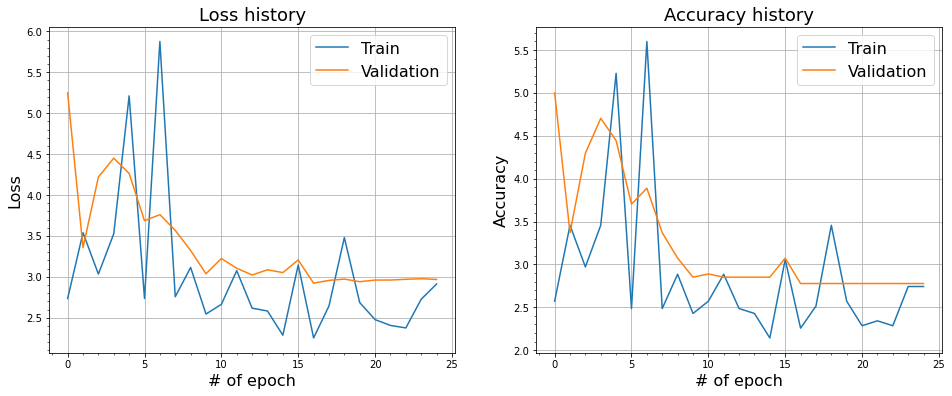

In [ ]:
plot_history(loss_train, loss_test, acc_train, acc_test)